In [104]:
import pandas as pd
import datetime
import numpy as np
from numpy import mean
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,RepeatedStratifiedKFold,GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.naive_bayes import ComplementNB
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
import seaborn as sns
import scipy.stats as stats
import pickle as pkl
!pip install shap
import shap
import mlflow

ModuleNotFoundError: No module named 'mlflow'

In [42]:
sf = pd.read_pickle('sf_transformed.pkl')

In [43]:
features = sf.drop(columns='arrest_made')

In [22]:
X = features
y = sf.arrest_made
y = y.astype('bool')

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [24]:
X_train.columns
# y_train.value_counts()

Index(['subject_age', 'contraband_found', 'search_conducted', 'subject_race',
       'gender'],
      dtype='object')

In [70]:
rand_forest = RandomForestClassifier(max_depth=3,min_samples_split=1000, random_state=46)
rand_forest.fit(X_train, y_train)
print("Random Forest Classifier Score:")
print("Training: {:6.2f}%".format(100*rand_forest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rand_forest.score(X_test, y_test)))
print("F1: {:6.2f}%".format(f1_score(y, rand_forest.predict(X), average='weighted')))
# print("F-Beta: {:6.2f}%".format(100*rand_forest.score(X_test, y_test)))


Random Forest Classifier Score:
Training:  86.45%
Test set:  86.82%
F1:   0.80%


In [8]:
# from imblearn.over_sampling import ADASYN
# X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [30]:
comp_naive = ComplementNB()
comp_naive.fit(X_train, y_train)
print("Complement Naive Bayes Classifier Score:")
print("Training: {:6.2f}%".format(100*comp_naive.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*comp_naive.score(X_test, y_test)))
print("F1: {:6.2f}%".format(f1_score(y, comp_naive.predict(X), average='weighted')))

Complement Naive Bayes Classifier Score:
Training:  82.16%
Test set:  82.85%
F1:   0.82%


In [52]:
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)

In [60]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LogisticRegression(solver='liblinear', class_weight='balanced')
grid = GridSearchCV(estimator=log_reg, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(X,y)

In [62]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.646736 using {'class_weight': {0: 1, 1: 100}}
0.640836 (0.017179) with: {'class_weight': {0: 100, 1: 1}}
0.644304 (0.016845) with: {'class_weight': {0: 10, 1: 1}}
0.645343 (0.016675) with: {'class_weight': {0: 1, 1: 1}}
0.646435 (0.016446) with: {'class_weight': {0: 1, 1: 10}}
0.646736 (0.016388) with: {'class_weight': {0: 1, 1: 100}}


In [91]:
log_reg = LogisticRegression(penalty='l1',class_weight={0: 100, 1: 1},random_state=42,solver='liblinear',max_iter=1000)
log_reg.fit(X_train, y_train)
print("Logistic Regression Classifier Score:")
print("Training: {:6.2f}%".format(100*log_reg.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*log_reg.score(X_test, y_test)))
print("F1: {:6.2f}%".format(f1_score(y, log_reg.predict(X), average='weighted')))
foo = log_reg.predict_proba(X)
foo

Logistic Regression Classifier Score:
Training:  86.45%
Test set:  86.82%
F1:   0.80%


array([[0.99874316, 0.00125684],
       [0.99496276, 0.00503724],
       [0.99894458, 0.00105542],
       ...,
       [0.99879834, 0.00120166],
       [0.99853525, 0.00146475],
       [0.99887198, 0.00112802]])

In [78]:
original_variables = list(X_train.columns)
zipped_together = list(zip(original_variables, log_reg.coef_[0]))
coefs = [list(x) for x in zipped_together]
coefs = pd.DataFrame(coefs, columns=["Variable", "Coefficient"])
coefs.sort_values(by=["Coefficient"], axis=0, inplace=True, ascending=False)
coefs

,Variable,Coefficient
1,contraband_found,1.523307
0,subject_age,0.003332
3,subject_race,-0.041626
4,gender,-0.043603
2,search_conducted,-3.281785


In [100]:
table = sf.groupby(by="arrest_made").sum().values
oddsratio, pvalue = stats.fisher_exact(table)
print("Odds Ratio: ", oddsratio, "p-value:", pvalue)

Odds Ratio:  0.9881131197723968 p-value: 0.5250246826428611


Text(0.5, 1, 'Logistic Regression Confusion Matrix')

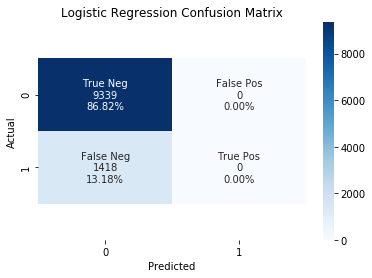

In [65]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
lr_confusion = confusion_matrix(y_test, log_reg.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                lr_confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     lr_confusion.flatten()/np.sum(lr_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(lr_confusion, annot=labels,fmt='' ,cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("K-Nearest Neighbors Classifier Score:")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

K-Nearest Neighbors Classifier Score:
Training:  84.70%
Test set:  84.71%


Text(0.5, 1, 'KNN Confusion Matrix')

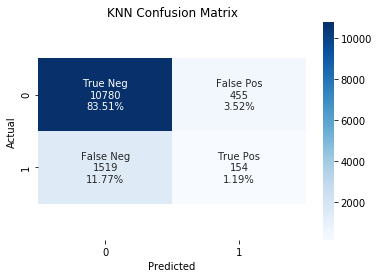

In [15]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                knn_confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     knn_confusion.flatten()/np.sum(knn_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(knn_confusion, annot=labels,fmt='' ,cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')

In [16]:
sv = svm.SVC()
sv.fit(X_train, y_train)
print("Support Vector Machines Score:")
print("Training: {:6.2f}%".format(100*sv.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*sv.score(X_test, y_test)))

Support Vector Machines Score:
Training:  86.32%
Test set:  87.04%


In [17]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

In [18]:
kmeans.cluster_centers_

array([[26.13003009,  0.12015795,  1.        ,  1.89601354,  0.82437006],
       [46.95218178,  0.1873163 ,  1.        ,  1.90764187,  0.83664933]])